# Temporary Notebook for developing new Data prep Process


In [1]:
from collections import defaultdict
from collections import Counter

import pandas as pd
from shapely.geometry import Polygon


In [2]:
# Local functions and classes
from types_and_classes import *
from utilities import *
from contours import *
from contour_graph import *
from debug_tools import *
#from structures import *
from region_slice import *
#from structure_set import *
from relations import *


### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

### Convert contour points to polygons and sort them by area


1. Start with list of dictionaries of contour coordinates 
    - Each dictionary contains the following items: 
        - ROI number 
            - Int ROI reference 
        - SliceIndex 
            - Float Z coordinate 
        - Coordinates 
            - List of coordinate points that form a closed polygon. 
2. Generate a contours DataFrame from the dictionary 
3. Convert each list of coordinate points to a polygon and validate it. 
4. Sort the contours DataFrame rows by  
    - ROI 
    - SliceIndex 
    - Polygon area (decreasing) 

**SliceSequence** 

- Ordered list of all slice indexes in use 
- This sequence represents only the original contour slice indexes 
- **INIT**(Series of SliceIndex) 
    1. Take the SliceIndex column from the contours DataFrame  
    1. Remove duplicates 
    1. Sort (increasing) 
    1. Set SliceIndex as the DataFrame index, but keep it as a column 
    1. Combine as a 3-column DataFrame 
        - ThisSlice:  SliceIndex,  
        - NextSlice: SliceIndex shifted by + 1,  
        - PreviousSlice: SliceIndex shifted by - 1 
    1. Add a column 'Original' and set all values to True. 
- **get_neighbors**(SliceIndex) 
    > Return: 
    > - (*NextSlice*, *PreviousSlice*) for a given SliceIndex,  
    > - *None* if the  given SliceIndex is not in the sequence 

### Create identify contours that are holes and build a graph of the contours

#### Create an graph of the contours for the ROI

**Find Contour Neighbours**

- For each Node in the ROI-specific Contour Graph, *starting with the first SliceIndex*:

1. Use the SliceSequence to obtain the Next SliceIndex.
2. Find all Contour nodes of the same hole type *(IsHole True or IsHole False)* with that Next SliceIndex.
3. If the Hulls of the two polygons overlap:
    > 1. Create an edge between the two Contour nodes
    > 2. Set a contourMatch attribute to the edge with the two Contour nodes as values.
    > 3. Set the Thickness of the edge to the difference between the two SliceIndexes.

4. For each Node in the ROI-specific ContourGraph calculate a Thickness from its edges.

**Contour Boundaries**
1. Select all Contour nodes in the ContourGraph with only one edge (degree=1)
2. For each of these nodes:
    1. Generate an interpolated boundary Contour 
        > - The contour is located half way between the boundary contour slice 
            and the neighbour slice that is not linked with an edge.
        > - set IsInterpolated to True
        > - set IsBoundary is True
        > - set IsHole matches the IsHole value of the non-interpolated Contour 
    1. Add the interpolated SliceIndex to SliceSequence:
        > - set 'Original' = False
        > - If the boundary contour SliceIndex  < the interpolated SliceIndex 
            >> - set 'PreviousSlice' = boundary contour SliceIndex, 
            >> - set NextSlice'= None
        > - Else:
            >> - set 'NextSlice'= boundary contour SliceIndex, 
            >> - set 'PreviousSlice '= None
    1. Add the interpolated contour to the contour graph .
    1. Add a ContourMatch edge between the original boundary contour and the interpolated contour.

**EnclosedRegionGraph**
- SubGraph of ContourGraph
- Identified as all nodes in ContourGraph that have a path between them
- Has a unique RegionIndex


**EnclosedRegions**
1. Create an EnclosedRegion SubGraph for each collection of nodes in the ContourGraph that are connected by a path.
2. For each EnclosedRegion:
    1. Create a new EnclosedRegionLabel.
    2. For each Contour node in the EnclosedRegion.
        1. Set Contour.RegionIndex to the EnclosedRegionLabel.
        2. Increment and Identify and label continuous contour regions.
        
**Note:** *Changes to the Contour nodes must reflect in the nodes of the ContourGraph*


**Open (External) Holes**
1. For each EnclosedRegion that is a hole:
    1. Select its boundary contours.
    2. Check whether there is a non-hole contour on the next slice that completely contains the hole boundary.
    3. If any hole boundary does not have a non-hole contour on the next slice that completely contains that hole boundary, then the hole is ***Open*** (external).
    4. If all hole boundaries have a non-hole contour on the next slice that completely contains that hole boundary, then the hole is ***Closed*** (internal).



### RegionSlices


**RegionSlice**

RegionSlice is generated by adding all contours from the same EnclosedRegion and SliceIndex, subtracting all holes.  

  - Related External holes are stored as a separate MultiPolygon attribute.
  - RegionIndex
  - SliceIndex
  - Polygon
  - ExternalHoles
  - Boundaries
  - Thickness
  - Contours
      - List of associated ContourIndexes

**INIT**

1. Receive all Contours from an EnclosedRegion with that SliceIndex.
1. Populate the Contours attribute with a list of the node labels for the supplied Contours.
1. Create a MultiPolygon by combining the Contour polygons that are not holes and not boundaries.
1. Subtract the Contour polygons that are holes from the MultiPolygon
1. Store the MultiPolygon in the Polygon attribute.
1. Create another MultiPolygon by combining all boundary contours and subtracting all hole boundaries. store this in the Boundaries attribute.
1. Create a third MultiPolygon by combining all External holes and store this in the ExternalHoles attribute.
        


**EnclosedRegionTable**

- RegionIndex
- SliceIndex
- RegionSlice


1. Create an EnclosedRegionTable
2. For each SliceIndex in each EnclosedRegion: 
    1. Create a RegionSlice using all Contours from the EnclosedRegion with that SliceIndex
    2. Calculate an approximate thickness value and set the RegionSlice Thickness attribute.
        - Thickness = sum(edge.thickness*edge.combined_area)/sum(edge.combined_area)
    3. Add the RegionSlice to the EnclosedRegionTable 
3. Place the EnclosedRegionTable and ContourGraph in a Structure


### Structures 

For each ROI: 

1. Create a ContourGraph 
2. Create an EnclosedRegionTable
3. Create a Structure 


**Structure**

*Attributes:*

  - ROI Number 
  - ID (name)
  - ContourGraph 
  - EnclosedRegionTable 
  - Physical volume 
  - External volume 
  - Hull volume 

**Node Volume**
- The volume of a node is approximated by a set of pseudo-cylinders
- Each pseudo-cylinder is height is half of the gap between the node and one of 
   its neighbours.
- the volume of the cylinder is the area of the cylinder times the half of the 
  gap.
- If the node has only one neighbour in a given direction (positive or negative), 
  then the area of the cylinder is the weighted average of the area of the node 
  and its neighbour.
  - The weight of the node area is 0.75 and the weight of the neighbouring 
    area is 0.25.
  - These weights are used to approximate the volume of the node as a cylinder 
     in the region that is half of the gap between the node and the neighbour.
- If the node has only one neighbour in each direction and the same gap, then 
  the volume of the node becomes the volume of a cylinder with the height equal 
  to the gap and area as 0.75 times the area of the node and 0.25 times the 
  area of the neighbouring nodes.
  > $\bar{A_i} = \frac{3}{4}A_N + \frac{1}{4}A_i$

- If the node has more than one neighbour in a given direction, then the volume of the 
  node is approximated by the sum of the volumes of the pseudo-cylinders 
  between the node and its neighbours.
- The sum of the areas of the pseudo-cylinders will be between the area of the 
  node and the area of the neighbouring nodes.
  > $\bar{A_i} = \frac{3\tilde{A_N} + A_i}{4}$<br><br>
  > $\tilde{A_N} = A_n\frac{A_i}{\sum{A_i}}$<br><br>
  > $\bar{A_i} = \frac{A_i}{4}\left(\frac{3A_N}{\sum{A_i}} + 1\right)$

- If the node has only one neighbour in a given direction, the weighting factor becomes:
  > $\bar{A_i} = \frac{A_i}{4}\left(\frac{3A_N}{A_i} + 1\right)$<br><br>
  > $\bar{A_i} = \frac{3}{4}A_N + \frac{1}{4}A_i$
  > Which agrees with the previous case.

The *combined area* ($A_c$) of an edge is the sum of the area of both nodes on the edge.  Rewriting the equation for the weighted area in terms of $A_N$ and $A_c$ gives:
  > $A_c = A_N + A_i$<br><br>
  > $\sum{A_i} = \sum{A_c} - n_iA_N$<br><br>
  > $\bar{A_i} = \frac{A_i}{4}\left(\frac{3A_N}{\sum{A_c} - n_iA_N} + 1\right)$<br><br>
  > $\bar{A_i} = \frac{A_i}{4}\left(\frac{3}{\sum{\frac{A_c}{A_N}} - n_i} + 1\right)$<br><br>

- The volume of the node is the sum of the volumes of the pseudo-cylinders multiplied by the thickness of the corresponding edges.
  
> Note: There is a difference between averaging by radius (r) and averaging by area ($r^2$) and averaging by volume ($r^3$).


**Calculate Structure volumes**

- **Physical** 
    1. For each node in ContourGraph: 
        1. Get the pseudo-area of the region between the node and each of its neighbours.
        2. Calculate a slice volume as area * thickness 
        3. If the node is a hole set the volume as negative 
    1. Sum the slice volumes 

- **Exterior** 
    1. For each node in ContourGraph: 
        1. Get the area of the polygon 
        1. Get an approximate thickness value (based on all edges connected to the node). 
            - Thickness = sum(edge.thickness*edge.combined_area)/sum(edge.combined_area) 
        1. Calculate a slice volume as area * thickness 
        1. If the node is an open (exterior) hole set the volume as negative 
        1. If the node is a closed (interior) hole set the volume to zero
    1. Sum the slice volumes 

- **Hull** 
    1. For each node in ContourGraph: 
        1. Get the area of the convex hull of the Polygon
        1. Calculate a slice volume as area * thickness 
        1. If the node is a hole set the volume to zero 
    1. Sum the slice volumes

 

### Create interpolated slices as needed for each contour graph
1. Find all slice indexes that are not original
2. For each slice index:
    1. use contour_lookup to determine if that slice exists in the contour graph.'
    2. If it does not exist, but the previous and next slices do, and have the same region index:
        1. create an interpolated contour at the specified index.
        2. set the IsInterpolated attribute to True.
        3. set the region index to the region index of the previous slice.
        4. set the IsBoundary attribute to False
        4. add the interpolated contour to the contour graph.
        5. Add edges to the contour graph between the interpolated contour and the previous and next slices.


## Data Processing Tests

- use the hole_test_contour_table function since it is the most complete.
- Check the data in the columns
- ROI, SliceIndex, HoleType, Interpolated, Boundary,  RegionIndex,
- and Label
- ROI should have the same value for the entire column
- SliceIndex should be sorted in ascending order. It should have values
- from 0 to 5 and half integer values for the boundaries
- Contours that are boundaries should also be interpolated.
- The hole type should be "None" for all contours that are not holes.
- Label should be a tuple of the ROI, the SliceIndex and the ContourIndex.
- ROI 1 should have boundaries on slice 0.5 and 4.5,
- the hole region should be "Open" at both ends.
- It should have two regions.
- ROI 2 should have boundaries on slice 0.5, 1.5, 3.5 and 4.5,
- the hole region should be "Closed".
- It should have two regions.

In [5]:
def single_box_example():
    slice_spacing = 0.1
    # Body structure defines slices in use
    box3 = make_box(roi_num=1, width=3, spacing=slice_spacing)
        # combine the contours
    slice_data = box3
    return slice_data

- Box Width = 3
- Slice area = 9
- Slice Spacing = 0.1

- Volume of each node = 3 * 3 * 0.1 = 0.9

Ideal volume is $3 \times 3 \times 3 = 27$

Actual volume should be  a bit less than $3 \times 3 \times (3 + 0.1) = 27.9$

- The extra volume is due to the 1/2 slice projection of the box in the Z direction
- but is reduced slightly due to interpolation of the slice area

In [6]:
def box_with_hole_example():
    slice_spacing = 0.1
    # Body structure defines slices in use
    box6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    box3 = make_box(roi_num=1, width=3, spacing=slice_spacing)
    # combine the contours
    slice_data = box6 + box3
    return slice_data

- Box Width = 6
- Slice area = 6x6 = 36
- Hole Width = 3
- Hole area = 3 x 3 = 9
- Slice Spacing = 0.1

- Volume of each node = (6 * 6 - 3 * 3) * 0.1 = (36 - 9) * 0.1 = 2.7

- Ideal volume is $6 \times 6 \times 6 - 3 \times 3 \times 3 = 216 - 27 = 189$

- Actual volume should be a bit less than 
$6 \times 6 \times (6 + 0.1) - 3 \times 3 \times (3 + 0.1) = 219.6 - 27.9 = 191.7$

> - The extra volume is due to the 1/2 slice projection of the box in the Z direction
> - but is reduced slightly due to interpolation of the slice area

- External volume is the same as the ideal volume, but without the holes subtracted.
- External volume should be a bit less than 
$6 \times 6 \times (6 + 0.1) = 219.6$


In [7]:
def two_boxes_example():
    slice_spacing = 0.1
    # Body structure defines slices in use
    box3_left = make_box(roi_num=1, width=3, offset_x=-2, spacing=slice_spacing)
    box3_right = make_box(roi_num=1, width=3, offset_x=2, spacing=slice_spacing)
    # combine the contours
    slice_data = box3_left + box3_right
    return slice_data

In [8]:
def square_tube_example():
    slice_spacing = 0.1

    # Body structure defines slices in use
    box6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    box3 = make_box(roi_num=1, width=3, height=6,spacing=slice_spacing)
    # combine the contours
    slice_data = box6 + box3
    return slice_data

In [9]:
def embedded_boxes_example():
    slice_spacing = 0.5
    # Body structure defines slices in use
    box6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    box3 = make_box(roi_num=2, width=3, spacing=slice_spacing)
    # combine the contours
    slice_data = box6 + box3
    return slice_data

In [10]:
def hollow_horizontal_cylinder_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=16, offset_z=0,
                                  spacing=slice_spacing)
    outer_cylinder = make_horizontal_cylinder(roi_num=1, radius=6, length=10,
                                              spacing=slice_spacing)
    cylinder_hole = make_horizontal_cylinder(roi_num=1, radius=4, length=10,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = outer_cylinder + cylinder_hole + body
    return slice_data


In [11]:
def embedded_spheres_example():
    slice_spacing = 0.5
    # Body structure defines slices in use
    sphere6 = make_sphere(roi_num=1, radius=3, spacing=slice_spacing)
    sphere3 = make_sphere(roi_num=2, radius=1.5, spacing=slice_spacing)
    # combine the contours
    slice_data = sphere6 + sphere3
    return slice_data

In [12]:
def multiple_spheres_example():
    slice_spacing = 0.5
    body = make_sphere(roi_num=0, radius=3, spacing=slice_spacing)
    left_sphere = make_sphere(roi_num=1, radius=2, offset_x=-2.5, offset_z=0,
                              spacing=slice_spacing)
    right_sphere = make_sphere(roi_num=1, radius=2, offset_x=2.5, offset_z=0,
                               spacing=slice_spacing)
    right_middle_sphere = make_sphere(roi_num=2, radius=1, offset_x=2.5, offset_z=0,
                                    spacing=slice_spacing)
    # combine the contours
    slice_data = left_sphere + right_sphere + right_middle_sphere + body
    return slice_data

In [13]:
def surrounded_horizontal_cylinder_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=16, offset_z=0,
                                  spacing=slice_spacing)
    outer_cylinder = make_horizontal_cylinder(roi_num=1, radius=6, length=10,
                                              spacing=slice_spacing)
    cylinder_hole = make_horizontal_cylinder(roi_num=1, radius=5, length=8,
                                             spacing=slice_spacing)
    surrounded_cylinder = make_horizontal_cylinder(roi_num=2, radius=3, length=6,
                                                   spacing=slice_spacing)
    # combine the contours
    slice_data = body + outer_cylinder + cylinder_hole + surrounded_cylinder
    # convert contour slice data into a table of slices and structures
    return slice_data

In [14]:
def shelters_horizontal_cylinder_single_side_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=16, offset_z=0,
                                  spacing=slice_spacing)
    outer_cylinder = make_horizontal_cylinder(roi_num=1, radius=6, length=10,
                                              spacing=slice_spacing)
    cylinder_hole = make_horizontal_cylinder(roi_num=1, radius=4, length=8,
                                             offset_x=1, offset_z=0,
                                             spacing=slice_spacing)
    surrounded_cylinder = make_horizontal_cylinder(roi_num=2, radius=3,
                                                   length=6, offset_x=1,
                                                   spacing=slice_spacing)
    # combine the contours
    slice_data = outer_cylinder + cylinder_hole + surrounded_cylinder + body
    return slice_data


In [15]:
def sphere_in_shell_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=16, length=20, offset_z=0,
                                    spacing=slice_spacing)
    sphere12 = make_sphere(roi_num=1, radius=6, spacing=slice_spacing)
    hole10 = make_sphere(roi_num=1, radius=5, spacing=slice_spacing)
    sphere6 = make_sphere(roi_num=2, radius=3, spacing=slice_spacing)

    # combine the contours
    slice_data = body + sphere12 + hole10 + sphere6
    return slice_data

In [16]:
def hole_test_contour_table():
    '''Create a contour table for testing set_enclosed_regions function.

    The test table contains the following data:
        ROI 0: The background region that defines the set of all slice indexes.
            slices, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0
        ROI 1: 1 contour with an embedded hole on slices 1.0 to 4.0,
            results in open hole
        ROI 2: 1 contour on slices 1.0 to 4.0,
               an embedded hole on slices 2.0 and 3.0,
               results in a closed hole.
        ROI 3: 1 contour on slices 1.0 to 4.0,
               an embedded hole on slices 1.0 and 3.0,
               results in a open hole.
    '''
    box1= box_points(width=1)
    box3_right = box_points(width=3, offset_x=-1.5)
    box1_right = box_points(width=1, offset_x=-1.5)
    box3_left = box_points(width=3, offset_x=1.5)
    box1_left = box_points(width=1, offset_x=1.5)
    box3_ant = box_points(width=3, offset_y=1.5)
    box1_ant = box_points(width=1, offset_y=1.5)
    slice_data = [
       ContourPoints(box1, roi=0, slice_index=0.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=1.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=2.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=3.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=4.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=5.0),        # ROI 0, Area 1

       ContourPoints(box3_right, roi=1, slice_index=1.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=1.0),  # ROI 1, Hole
       ContourPoints(box3_right, roi=1, slice_index=2.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=2.0),  # ROI 1, Hole
       ContourPoints(box3_right, roi=1, slice_index=3.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=3.0),  # ROI 1, Hole
       ContourPoints(box3_right, roi=1, slice_index=4.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=4.0),  # ROI 1, Hole

       ContourPoints(box3_left, roi=2, slice_index=1.0),  # ROI 2, Area 4
       ContourPoints(box3_left, roi=2, slice_index=2.0),  # ROI 2, Area 4
       ContourPoints(box1_left, roi=2, slice_index=2.0),  # ROI 2, Hole
       ContourPoints(box3_left, roi=2, slice_index=3.0),  # ROI 2, Area 4
       ContourPoints(box1_left, roi=2, slice_index=3.0),  # ROI 2, Hole
       ContourPoints(box3_left, roi=2, slice_index=4.0),  # ROI 2, Area 4

       ContourPoints(box3_ant, roi=3, slice_index=1.0),  # ROI 3, Area 4
       ContourPoints(box1_ant, roi=3, slice_index=1.0),  # ROI 3, Hole
       ContourPoints(box3_ant, roi=3, slice_index=2.0),  # ROI 3, Area 4
       ContourPoints(box1_ant, roi=3, slice_index=2.0),  # ROI 3, Hole
       ContourPoints(box3_ant, roi=3, slice_index=3.0),  # ROI 3, Area 4
       ContourPoints(box1_ant, roi=3, slice_index=3.0),  # ROI 3, Hole
       ContourPoints(box3_ant, roi=3, slice_index=4.0),  # ROI 3, Area 4
    ]
    contour_table, slice_sequence = build_contour_table(slice_data)
    return contour_table, slice_sequence


## Test RegionSlice

## Apply Data Preprocess to the data

In [17]:
slice_data = single_box_example()
contour_table, slice_sequence = build_contour_table(slice_data)
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=1)
Counter(dict(contour_graph.degree).values())

Counter({2: 31, 1: 2})

In [18]:
contour_table, slice_sequence = hole_test_contour_table()
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=0)
degrees = Counter(dict(contour_graph.degree).values())
degrees

Counter({2: 6, 1: 2})

In [19]:
slice_sequence.slices

[-0.5, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.5]

In [20]:
contour_table, slice_sequence = hole_test_contour_table()
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=3)
degrees = Counter(dict(contour_graph.degree).values())
degrees

Counter({2: 6, 1: 5, 3: 1})

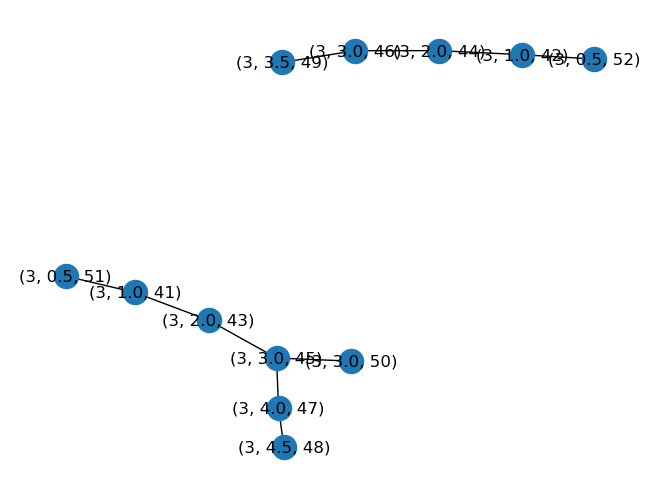

In [21]:
nx.draw(contour_graph, with_labels=True)
plt.show()

## Boundary examples for regions with holes

#### Exterior holes touching each other

<table>
<tr>
<td><img src="Images/Boundaries/Exterior holes touching each other.png" alt="Exterior holes touching each other"></td>
<td><img src="Images/Boundaries/Exterior holes touching each other Boundary slice.png" alt="Boundary Slice"></td>
</tr>
</table>

- interpolated slices contain: 
    - *boundaries* with single MultiPolygon containing both contours
    - *regions* is empty  (because both contours are boundaries).


In [22]:
A = (shapely.Polygon(circle_points(2)) -
     shapely.Polygon(circle_points(1.3)))
A_exterior =  (shapely.Polygon(circle_points(2)) -
     shapely.Polygon(circle_points(1.3)))
A_hull = shapely.Polygon(circle_points(2))
A_hole = shapely.Polygon(circle_points(1.3))

B = (shapely.Polygon(circle_points(2)) -
     shapely.Polygon(circle_points(1.3)))
B_hole = shapely.Polygon(circle_points(1.3))

print(A.relate(B))
print(A_exterior.relate(B))
print(A_hull.relate(B))


#print(A_hole.relate(B))
#print(A_hole.relate(B_hole))
#print(A.relate(B_hole))

2FFF1FFF2
2FFF1FFF2
212F1FFF2


<style type="text/css">
table {border-style:solid;border-width:1px;border-collapse:collapse;border-spacing:1;}
td {font-family:Arial, sans-serif;font-size:12px;color: #000000; 
    text-align:center;vertical-align:middle;overflow:hidden; 
    padding:3px 3px;word-break:normal}
.tg-b-head{background-color: #8ED973;font-size:16px;font-weight:bold;
           border-bottom: 3px solid #156082}
.tg-a-head{background-color: #61CBF3;font-size:16px;font-weight:bold;
           border-right: 3px solid #156082}
.tg-group{background-color: #61CBF3;font-size:14px;font-weight:bold}
.tg-dim-top{background-color: #A02B93;color: #FFFFFF;font-weight:bold;
            border-color: #000000; border-bottom: 4px solid #FFFFFF}
.tg-dim-left{background-color: #A02B93;color: #FFFFFF;font-weight:bold;
             border-color: #000000;border-right: 4px solid #FFFFFF}
.tg-group-border{border-right: 10px solid #F1A983}
.tg-bit{background-color: #F2CEEF}
</style>

<table style="background-color: #FFFFFF">
<tr>
  <td>Initial Relation Binary</td>
  <td>After Boundary correction</td>
  <td>After Hole correction</td>
</tr>
<tr><td>
  <table><tbody>
    <tr> <td colspan="2" rowspan="3"></td> 
        <td class="tg-b-head" colspan="9">B</td>
    </tr>
    <tr><td class="tg-group tg-group-border" colspan="3">Region</td>
        <td class="tg-group tg-group-border" colspan="3">Exterior</td>
        <td class="tg-group" colspan="3">Hull</td>
    </tr>
    <tr><td class="tg-dim-top">I</td><td class="tg-dim-top">B</td>
        <td class="tg-dim-top tg-group-border">E</td>
        <td class="tg-dim-top">I</td><td class="tg-dim-top">B</td>
        <td class="tg-dim-top tg-group-border">E</td>
        <td class="tg-dim-top">I</td><td class="tg-dim-top">B</td>
        <td class="tg-dim-top">E</td>
    </tr>
    <tr>
      <td class="tg-a-head" rowspan="3">A</td>
      <td class="tg-dim-left">I</td>
      <td class="tg-bit">2</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit tg-group-border">F</td>
      <td class="tg-bit">2</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit tg-group-border">F</td>
      <td class="tg-bit">2</td>
      <td class="tg-bit">1</td>
      <td class="tg-bit">2</td>
    </tr>
    <tr>
      <td class="tg-dim-left">B</span></td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">1</td>
      <td class="tg-bit tg-group-border">F</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">1</td>
      <td class="tg-bit tg-group-border">F</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">1</td>
      <td class="tg-bit">F</td>
    </tr>
    <tr>
      <td class="tg-dim-left">E</span></td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit tg-group-border">2</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit tg-group-border">2</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">F</td>
      <td class="tg-bit">2</td>
    </tr>
  </tbody></table>

#### Interior hole with nested structure touching hole (Internal Boundary / Nested)
<table>
<tr>
<td><img src="Images/Boundaries/Interior hole with nested structure touching hole.png" alt="Interior hole with contained structure not touching hole"></td>
<td><img src="Images\Boundaries\Interior hole with nested structure touching hole slice.png" alt="Boundary slice"></td>
</tr>
</table>

- Hole Starts on the same slice as the secondary structure
- Exterior contour is not a boundary Just hole & internal boundary
- Should show  boundaries touching
- Exterior - Hole will produce disjoint

- interpolated slice of A contains:
    - *boundaries* with empty MultiPolygon (no boundaries at this slice)
    - *regions* with single MultiPolygon containing both contours
- interpolated slice of B contains:
    - *boundaries* with single MultiPolygon containing contour
    - *regions* is empty?  - because contour is boundary.


In [23]:
A = shapely.MultiPolygon([shapely.Polygon(circle_points(2)) -
                          shapely.Polygon(circle_points(1.3))])
A_exterior =  shapely.MultiPolygon([shapely.Polygon(circle_points(2))])
A_hull = shapely.MultiPolygon([shapely.Polygon(circle_points(2))])

B = shapely.MultiPolygon([shapely.Polygon(circle_points(1))])


In [24]:
print('Non-Boundary Relation')
print(DE9IM(A,B).relation_str)
print(DE9IM(A,B))
print('Hole in A and B with no corrections')
print(DE9IM(A_hole,B).relation_str)
print(DE9IM(A_hole,B))
print('Hole in A and B with boundary corrections')
print(DE9IM(A_hole,B).boundary_adjustment('a').boundary_adjustment('b').relation_str)
print(DE9IM(A_hole,B).boundary_adjustment('a').boundary_adjustment('b'))
print('Hole in A and B with boundary and hole corrections')
print(DE9IM(A_hole,B).boundary_adjustment('a').boundary_adjustment('b').hole_adjustment('a').relation_str)
print(DE9IM(A_hole,B).boundary_adjustment('a').boundary_adjustment('b').hole_adjustment('a'))

Non-Boundary Relation
FF2FF1212
|001|
|001|
|111|
Hole in A and B with no corrections
212FF1FF2
|111|
|001|
|001|
Hole in A and B with boundary corrections
FFFF22FF2
|000|
|011|
|001|
Hole in A and B with boundary and hole corrections
FFFF22FFF
|000|
|011|
|000|


In [25]:
relation_raw = DE9IM(A_hole,B)
relation_boundary = relation_raw.boundary_adjustment('a').boundary_adjustment('b')
relation_corrected = relation_boundary.hole_adjustment('a')
print(relation_corrected.relation_str)
print(relation_corrected.to_bool())
print(relation_corrected.to_int())
print(bin(relation_corrected.to_int(shift=9) + relation_corrected.to_int()))

FFFF22FFF
000011000
24
0b11000000011000


In [26]:
non_boundary = DE27IM(relation_int=(DE9IM(A,B).to_int(shift=18) +
                                    DE9IM(A_exterior,B).to_int(shift=9) +
                                    DE9IM(A_hull,B).to_int()))
boundary = DE27IM(relation_int=(relation_corrected.to_int(shift=18)))
full_relation = non_boundary.merge(boundary)
print(full_relation)
print(full_relation.identify_relation())

|001|	|111|	|111|
|011|	|001|	|001|
|111|	|001|	|001|

Relationship: Confines


# Interpolated Region Slices
- All Boundary contours should be combined into a MultiPolygon in *boundaries*.
- *holes* and regular contours cannot be combined in the same MultiPolygon unless they are related.
- holes require a flag to indicate that they are holes.
- *regions* should contain the non-boundary contours.

- Boundary contours should not be combined with the region contours.

- *??? Each boundary contour should be a separate MultiPolygon. ???*

2. boundary slice for region that is an open hole
    - boundaries contains a single MultiPolygon  (the hole)
    - **??? regions contains an single MultiPolygon  (the outer contour) ???**
    - open_holes contains an empty MultiPolygon
    - **??? embedded_regions contains an empty list ???**
    - region_holes contains a single Contour
    - **??? contour_indexes contains a single ContourIndex ???**
    - is_interpolated is True

#### Exterior hole with structure touching hole
<table>
<tr>
<td><img src="Images/Boundaries/Exterior hole with structure touching hole.png" alt="Exterior hole with structure touching hole"></td>
<td><img src="Images/Boundaries/Exterior hole with structure touching hole slice.png" alt="Boundary slice"></td>
</tr>
</table>

- Exterior contour and hole share the bottom boundary
- Secondary structure shares a boundary with Primary hole
- Should show Borders

- interpolated slice of A contains:
    - *boundaries* with single MultiPolygon containing both contours
    - *regions* is empty  - because both contours are boundaries.
- interpolated slice of B contains:
    - *boundaries* with single MultiPolygon containing contour
    - *regions* is empty  - because contour is boundary.

In [27]:
A_boundary = shapely.MultiPolygon([shapely.Polygon(circle_points(2)) -
                          shapely.Polygon(circle_points(1.3))])

B_boundary = shapely.MultiPolygon([shapely.Polygon(circle_points(1.3))])


In [28]:
# If only the A contour is supplied, then A is exterior to B
exterior_a = DE9IM(relation_str=('FF1' * 3))  # 'FF1FF1FF1'
# If only the B contour is supplied, then B is exterior to A
exterior_b = DE9IM(relation_str=('F' * 3 + 'F' * 3 + '1' * 3))  # 'FFFFFF111'
both_exterior = exterior_a.merge([exterior_b])


In [29]:
print('Non-Boundary Relation')
print(both_exterior.relation_str)
print(both_exterior)
print('A and B boundaries with no corrections')
print(DE9IM(A_boundary,B_boundary).relation_str)
print(DE9IM(A_boundary,B_boundary))
print('A and B boundaries with boundary corrections')
print(DE9IM(A_boundary,B_boundary).boundary_adjustment('a').boundary_adjustment('b').relation_str)
print(DE9IM(A_boundary,B_boundary).boundary_adjustment('a').boundary_adjustment('b'))


Non-Boundary Relation
001001111
|001|
|001|
|111|
A and B boundaries with no corrections
FF2F112F2
|001|
|011|
|101|
A and B boundaries with boundary corrections
FFFF12F22
|000|
|011|
|011|


In [30]:
non_boundary = DE27IM(relation_int=(both_exterior.to_int(shift=18) +
                                    both_exterior.to_int(shift=9) +
                                    both_exterior.to_int()))
print('Non Boundary Relation')
print(non_boundary)
boundary = DE27IM(relation_int=(relation_corrected.to_int(shift=18)))
print('Boundary Relation')
print(boundary)
full_relation = non_boundary.merge(boundary)
print('Full Relation')
print(full_relation)
print(full_relation.identify_relation())

Non Boundary Relation
|001|	|001|	|001|
|001|	|001|	|001|
|111|	|111|	|111|

Boundary Relation
|000|	|000|	|000|
|011|	|000|	|000|
|000|	|000|	|000|

Full Relation
|001|	|001|	|001|
|011|	|001|	|001|
|111|	|111|	|111|

Relationship: Borders


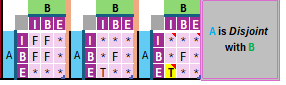

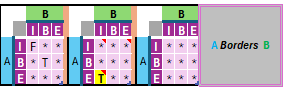

**The area external to A should contain some of the interior of B.**

**The interior of A, with holes filled, should contain some of the exterior of B. (there is no scenario where the interior of A, with holes filled, will not be larger than B)**

In [31]:
# padding is a string of 'FFFFFFFFF', which becomes 9 zeros when converted
# to binary.  Padding is used in cases where Exterior and Hull relationships
# are not relevant.
padding = 'F' * 9  # 'FFFFFFFFF'
# If only the A contour is supplied, then A is exterior to B
exterior_a = DE9IM(relation_str=('FF1' * 3))  # 'FF1FF1FF1'
# If only the B contour is supplied, then B is exterior to A
exterior_b = DE9IM(relation_str=('F' * 3 + 'F' * 3 + '1' * 3))  # 'FFFFFF111'
both_exterior = exterior_a.merge([exterior_b])
external = DE9IM(relation_str=padding)
convex_hull = DE9IM(relation_str=padding)
print(exterior_a)
print()
print(exterior_b)
print()
print(both_exterior)

|001|
|001|
|001|

|000|
|000|
|111|

|001|
|001|
|111|


#### Exterior hole disjoint with overlap (Disjoint)
<table>
<tr>
<td><img src="Images/Boundaries/Exterior hole with contained structure inside hole.png" alt="Interior hole with contained structure inside hole"></td>
<td><img src="Images/Boundaries/Interior hole with nested structure not touching hole slice.png" alt="Boundary slice"></td>
</tr>
</table>

- Exterior contour and hole share the bottom boundary
- Secondary structure is not a boundary
- Should show  disjoint


- interpolated slice of A contains:
    - *boundaries* with single MultiPolygon containing both contours
    - *regions* is empty  - because both contours are boundaries.
- interpolated slice of B contains:
    - *boundaries* is empty
    - *regions* with single MultiPolygon containing single contour


#### Interior hole with surrounded structure not touching hole (Surrounds)
<table>
<tr>
<td><img src="Images/Boundaries/Interior hole with nested structure not touching hole .png" alt="Interior hole with contained structure not touching hole"></td>
<td><img src="Images/Boundaries/Interior hole with nested structure not touching hole slice.png" alt="Boundary slice"></td>
</tr>
</table>

- Secondary structure is only boundary
- Exterior - Hole will produce disjoint
- Should show disjoint



- interpolated slice of A contains:
    - *boundaries*...
    - *regions* ...
- interpolated slice of B contains:
    - *boundaries* ...
    - *regions* ...


#### Interior hole with contained structure touching hole (Partition)
<table>
<tr>
<td><img src="Images/Boundaries/Interior hole with contained structure touching hole.png" alt="Interior hole with contained structure touching hole"></td>
<td><img src="Images/Boundaries/Interior hole with contained structure touching hole slice.png" alt="Boundary slice"></td>
</tr>
</table>

- Hole shares boundary slice with the secondary structure
- Should show  boundaries touching
- Exterior contour is not a boundary Just hole & internal boundary


- interpolated slice of A contains:
    - *boundaries*...
    - *regions* ...
- interpolated slice of B contains:
    - *boundaries* ...
    - *regions* ...


#### Exterior hole with structure touching both hole and exterior
![Exterior hole with structure touching both hole and exterior](<Images/Boundaries/Exterior hole with structure touching both hole and exterior.png>)
- interpolated slice of A contains:
    - *boundaries* with single MultiPolygon containing contour
    - *regions* is empty?  - because contour is boundary.
- interpolated slice of B contains:
    - *boundaries* with single MultiPolygon containing both contours
    - *regions* is empty?  - because both contours are boundaries.





#### Interior borders
![alt text](<Images/Boundaries/Interior Hole with structure of same length inside.png>)





**DE-27IM**
|_|Contour|_|Exterior|_|Hull  |
|-|------|-|-------|-|----|

| |I|B|E||I|B|E||I|B|E|
|-|-|-|-|-|-|-|-|-|-|-|-|
|I|F|*|*||T|*|*||*|*|*|
|B|*|T|*||*|T|*||*|*|*|
|E|*|*|*||*|*|*||*|*|*|


<style type="text/css">
table {border-style:solid;border-width:1px;border-collapse:collapse;border-spacing:1;}
td {font-family:Arial, sans-serif;font-size:12px;color: #000000; 
    text-align:center;vertical-align:middle;overflow:hidden; 
    padding:3px 3px;word-break:normal}
.tg-b-head{background-color: #8ED973;font-size:16px;font-weight:bold;
           border-bottom: 3px solid #156082}
.tg-a-head{background-color: #61CBF3;font-size:16px;font-weight:bold;
           border-right: 3px solid #156082}
.tg-group{background-color: #61CBF3;font-size:14px;font-weight:bold}
.tg-dim-top{background-color: #A02B93;color: #FFFFFF;font-weight:bold;
            border-color: #000000; border-bottom: 4px solid #FFFFFF}
.tg-dim-left{background-color: #A02B93;color: #FFFFFF;font-weight:bold;
             border-color: #000000;border-right: 4px solid #FFFFFF}
.tg-group-border{border-right: 10px solid #F1A983}
.tg-bit{background-color: #F2CEEF}
</style>
<table><tbody>
  <tr> <td colspan="2" rowspan="3"></td> 
       <td class="tg-b-head" colspan="9">B</td>
  </tr>
  <tr><td class="tg-group tg-group-border" colspan="3">Region</td>
      <td class="tg-group tg-group-border" colspan="3">Exterior</td>
      <td class="tg-group" colspan="3">Hull</td>
  </tr>
  <tr><td class="tg-dim-top">I</td><td class="tg-dim-top">B</td>
      <td class="tg-dim-top tg-group-border">E</td>
      <td class="tg-dim-top">I</td><td class="tg-dim-top">B</td>
      <td class="tg-dim-top tg-group-border">E</td>
      <td class="tg-dim-top">I</td><td class="tg-dim-top">B</td>
      <td class="tg-dim-top">E</td>
  </tr>
  <tr>
    <td class="tg-a-head" rowspan="3">A</td>
    <td class="tg-dim-left">I</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit tg-group-border">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit tg-group-border">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
  </tr>
  <tr>
    <td class="tg-dim-left">B</span></td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit tg-group-border">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit tg-group-border">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
  </tr>
  <tr>
    <td class="tg-dim-left">E</span></td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit tg-group-border">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit tg-group-border">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
    <td class="tg-bit">*</td>
  </tr>
</tbody></table>

## Boundary corrections
<table>
<tr>
    <th>Corrections for boundary in <i>A</i></th>
    <th>Corrections for boundary in <i>B</i></th>
    <th>Corrections for <i>A</i> and <i>B</i> as boundaries</th>
    </tr>
<tr>
    <td><img src="Images/Boundaries/a interior to boundary.png" alt="Boundary corrections for A" width="250"></td>
    <td><img src="Images/Boundaries/b interior to boundary.png" alt="Boundary corrections for A" width="250"></td>
    <td><img src="Images/Boundaries/a and b interior to boundary.png" alt="Boundary corrections for A" width="250"></td>
</tr>
</table>


## Hole Corrections
<table>
<tr>
    <th>Corrections for <i>A</i> as hole</th>
    <th>Corrections for <i>B</i> as hole</th>
    </tr>
<tr>
    <td><img src="Images\Boundaries\Correction for A as Hole.png" alt="Boundary corrections for A" width="300"></td>
    <td><img src="Images\Boundaries\Correction for B as Hole.png" alt="Boundary corrections for A" width="300"></td>
</tr>


# Interpolated Region Slices
- All Boundary contours should be combined into a MultiPolygon in *boundaries*.
- *holes* and regular contours cannot be combined in the same MultiPolygon unless they are related.
- holes require a flag to indicate that they are holes.
- *regions* should contain the non-boundary contours.



## TODO

- Need to create interpolated contour for all contour references of a boundary contour so that the related contours are set correctly.

- interpolated slice index can be obtained from the interpolated contour.

- Combine code from structures.generate_interpolated_contours() and contour_graph.add_boundary_contours() to create a generic function to identify the relevant neighbouring slices for interpolation.

- add a get_contour function that takes a ContourGraph and a contour index and returns the contour object.

- Combine code from structures.generate_interpolated_contours() and contour_graph.add_boundary_contours() to create a generic function to add an interpolated contour to the graph.

## generate_interpolated_contours design:
create a function to generate an interpolated contour for a given slice index in the contour graph.
- The function should take a contour graph, a slice sequence and a slice index (*this_slice*) as input.
- The function should take an optional argument for the slice index of the interpolated contour (*interpolated_slice*).
- The function should return an updated contour graph with the interpolated contour added.
- The function should check if *this_slice* is in the contour graph and raise an error if it is not.
- The neighbours of the *this_slice* node are obtained from the slice_sequence.
- If *interpolated_slice* is not provided, *this_slice* must reference a graph node with a degree of 1.  If not, raise an error.
- If *interpolated_slice* is not provided, the second slice index for the interpolation is the neighbouring slice index that is not adjacent to the *this_slice* node.
 - If *interpolated_slice* is provided, verify that it is located between *this_slice* and one of the neighbour slice index and select that slice index as the second slice index for the interpolation.
 - If a there is a node at the neighbour slice index which is adjacent to the *this_slice* node, then get the polygon from that node as the second polygon for the interpolation. if not, then the second polygon is None.
 - use `interpolate_polygon` to create the interpolated polygon.
 - The slice index of the interpolated contour can be obtained from the *Z* coordinate of the interpolated polygon.
 - After the interpolated polygon is created, create a Contour object.
 - The following attributes should match those of the *this_slice* node:
    - roi
    - is_hole
    - hole_type
    - is_boundary
- The following attributes should be:
    - is_interpolated = True
    - slice_index = interpolated_slice


In [32]:
def hole_test_contour_table():
    '''Create a contour table for testing set_enclosed_regions function.

    The test table contains the following data:
        ROI 0: The background region that defines the set of all slice indexes.
            slices, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0
        ROI 1: 1 contour with an embedded hole on slices 1.0 to 4.0,
            results in open hole
        ROI 2: 1 contour on slices 1.0 to 4.0,
               an embedded hole on slices 2.0 and 3.0,
               results in a closed hole.
        ROI 3: 1 contour on slices 1.0 to 4.0,
               an embedded hole on slices 1.0 and 3.0,
               results in a open hole.
    '''
    box1= box_points(width=1)
    box3_right = box_points(width=3, offset_x=-1.5)
    box1_right = box_points(width=1, offset_x=-1.5)
    box3_left = box_points(width=3, offset_x=1.5)
    box1_left = box_points(width=1, offset_x=1.5)
    box3_ant = box_points(width=3, offset_y=1.5)
    box1_ant = box_points(width=1, offset_y=1.5)
    slice_data = [
       ContourPoints(box1, roi=0, slice_index=0.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=1.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=2.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=3.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=4.0),        # ROI 0, Area 1
       ContourPoints(box1, roi=0, slice_index=5.0),        # ROI 0, Area 1

       ContourPoints(box3_right, roi=1, slice_index=1.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=1.0),  # ROI 1, Hole
       ContourPoints(box3_right, roi=1, slice_index=2.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=2.0),  # ROI 1, Hole
       ContourPoints(box3_right, roi=1, slice_index=3.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=3.0),  # ROI 1, Hole
       ContourPoints(box3_right, roi=1, slice_index=4.0),  # ROI 1, Area 4
       ContourPoints(box1_right, roi=1, slice_index=4.0),  # ROI 1, Hole

       ContourPoints(box3_left, roi=2, slice_index=1.0),  # ROI 2, Area 4
       ContourPoints(box3_left, roi=2, slice_index=2.0),  # ROI 2, Area 4
       ContourPoints(box1_left, roi=2, slice_index=2.0),  # ROI 2, Hole
       ContourPoints(box3_left, roi=2, slice_index=3.0),  # ROI 2, Area 4
       ContourPoints(box1_left, roi=2, slice_index=3.0),  # ROI 2, Hole
       ContourPoints(box3_left, roi=2, slice_index=4.0),  # ROI 2, Area 4

       ContourPoints(box3_ant, roi=3, slice_index=1.0),  # ROI 3, Area 4
       ContourPoints(box1_ant, roi=3, slice_index=1.0),  # ROI 3, Hole
       ContourPoints(box3_ant, roi=3, slice_index=2.0),  # ROI 3, Area 4
       ContourPoints(box1_ant, roi=3, slice_index=2.0),  # ROI 3, Hole
       ContourPoints(box3_ant, roi=3, slice_index=3.0),  # ROI 3, Area 4
       ContourPoints(box1_ant, roi=3, slice_index=3.0),  # ROI 3, Hole
       ContourPoints(box3_ant, roi=3, slice_index=4.0),  # ROI 3, Area 4
    ]
    contour_table, slice_sequence = build_contour_table(slice_data)
    return contour_table, slice_sequence


In [33]:
contour_table, slice_sequence = hole_test_contour_table()
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=3)

|SliceIndex|RegionIndex|HoleType|Interpolated|
|---|---|---|---|
|0.5|Area 2|Hole|Interpolated|
|1.0|Area 4|Hole|Original|
|2.0|Area 4|Hole|Original|
|3.0|Area 4|Hole|Original|
|3.5|Area 2|Hole|Interpolated|
|4.0|Area 4|-|Original|
|4.5|Area 2|-|Interpolated|

- Hole has 3 original contours and 2 interpolated contours on the ends.
- 3 nodes with degree 2 and 2 nodes with degree 1.
- Area has 4 original contours, 2 interpolated contours on the ends, and 1 interpolated contour in the middle (where Hole ends).
- 3 nodes with degree 2, 3 nodes with degree 1 (two ends and one middle), and 1 node with degree 3 (due to the interpolated contour in the middle).

**Graph Degrees**
|Degree|Count|
|---|---|
|3|1|
|2|6|
|1|5|

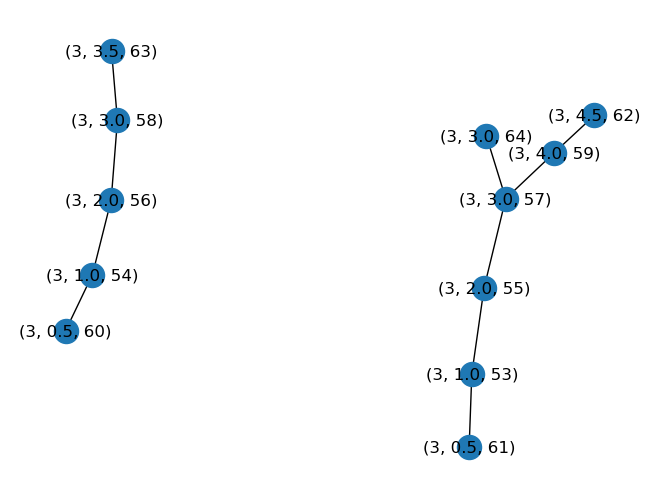

In [34]:
nx.draw(contour_graph, with_labels=True)
plt.show()

In [35]:
A = shapely.Polygon(circle_points(2))
B = shapely.Polygon(circle_points(2, offset_y=1))
C = shapely.Polygon(circle_points(2, offset_y=-1))


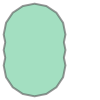

In [36]:
shapely.union_all([A, B, C])

In [37]:
I = interpolate_polygon([0,1], A, B)

In [38]:
I.has_z

True

In [39]:
I.boundary.coords[0][2]

0.5

## Testing RegionSlice

### Test Preprocessing
1. define the contours for the slices
2  Build the contour graph

Create RegionSlices for different slices

- Items to test:
    - regions, open_holes, exterior, hull, region_holes, embedded_regions, contour_indexes
        1. Slice with one contour
            - regions contains a single MultiPolygon
            - boundaries contains an empty MultiPolygon
            - open_holes contains an empty MultiPolygon
            - exterior is the same as the region
            - hull is the same as the region
            - embedded_regions contains an empty list
            - region_holes contains an empty list
            - contour_indexes contains a single ContourIndex
        2. Slice with two non-overlapping contours
            - regions contains two MultiPolygons
            - boundaries contains two empty MultiPolygons
            - open_holes contains two empty MultiPolygons
            - exterior is the same as the region
            - hull is the same as the region
            - embedded_regions contains an empty list
            - region_holes contains an empty list
            - contour_indexes contains two ContourIndexes
        3. Slice with two non-overlapping contours that are part of the same region
            - regions contains a single MultiPolygon that includes the two contours
            - boundaries contains an empty MultiPolygon
            - open_holes contains an empty MultiPolygon
            - exterior is the same as the region
            - hull is the convex hull of the region MultiPolygon
            - embedded_regions contains an empty list
            - region_holes contains an empty list
            - contour_indexes contains two ContourIndexes
        4. Slice with contour and an open hole
            - regions contains a single MultiPolygon
            - boundaries contains an empty MultiPolygon
            - open_holes contains the hole as a single MultiPolygon
            - exterior is the same as the region
            - hull contains the larger contour as a single MultiPolygon   
            - embedded_regions contains an empty list
            - region_holes contains a single Contour
            - contour_indexes contains two ContourIndexes
        5. Slice with contour and a closed hole
            - regions contains a single MultiPolygon
            - boundaries contains an empty MultiPolygon
            - open_holes contains an empty MultiPolygon
            - exterior contains the larger contour as a single MultiPolygon
            - hull is the convex hull of the region MultiPolygon
            - embedded_regions contains an empty list
            - region_holes contains a single Contour
            - contour_indexes contains two ContourIndexes
        6. Slice with contour, a closed hole and an island
            - regions contains a single MultiPolygon
            - boundaries contains an empty MultiPolygon
            - open_holes contains an empty MultiPolygon
            - exterior contains the larger contour as a single MultiPolygon
            - hull is the convex hull of the region MultiPolygon
            - embedded_regions contains  a single Contour
            - region_holes contains a single Contour
            - contour_indexes contains three ContourIndexes

    - boundaries, is_interpolated, contour_indexes
        1. boundary slice for region with one contour per slice
            - boundaries contains a single MultiPolygon
            - regions contains an empty MultiPolygon
            - open_holes contains an empty MultiPolygon
            - embedded_regions contains an empty list
            - region_holes contains an empty list
            - contour_indexes contains a single ContourIndex
            - is_interpolated is True

**Needs Fixing**
> Boundary contours should not be combined with the region contours.

> Each boundary contour should be a separate MultiPolygon.

2. boundary slice for region that is an open hole
    - boundaries contains a single MultiPolygon  (the hole)
    - **??? regions contains an single MultiPolygon  (the outer contour) ???**
    - open_holes contains an empty MultiPolygon
    - **??? embedded_regions contains an empty list ???**
    - region_holes contains a single Contour
    - **??? contour_indexes contains a single ContourIndex ???**
    - is_interpolated is True




# Testing RegionSlice

### Test Preprocessing
1. define the contours for the slices
2  Build the contour graph

Create RegionSlices for different slices

- Items to test:
    - regions, open_holes, exterior, hull, region_holes, embedded_regions, contour_indexes
        1. Slice with one contour
            - regions contains a single item with a single MultiPolygon
            - boundaries contains a single item with an empty MultiPolygon
            - open_holes contains a single item with an empty MultiPolygon
            - exterior is the same as the region
            - hull is the same as the region
            - embedded_regions contains a single item with an empty list
            - region_holes contains a single item with an empty list
            - contour_indexes contains a single item with a single ContourIndex
        2. Slice with two non-overlapping contours
            - regions contains two MultiPolygons
            - boundaries contains two items containing empty MultiPolygons
            - open_holes contains two items containing empty MultiPolygons
            - exterior is the same as the region
            - hull is the same as the region
            - embedded_regions contains two items each containing an empty list
            - region_holes contains two items each containing an empty list
            - contour_indexes contains two items, each a list containing a 
                single ContourIndex
        3. Slice with two non-overlapping contours that are part of the same region
            - regions contains a single MultiPolygon that includes the two 
                contours
            - boundaries contains two items containing empty MultiPolygons
            - open_holes contains two items containing empty MultiPolygons
            - exterior is the same as the region
            - hull contains a single item with the convex hull of the region 
                MultiPolygon
            - region_holes contains a single item with an empty list
            - contour_indexes contains a single item, a list with two 
                ContourIndexes
        4. Slice with contour and an open hole
            - regions contains a single MultiPolygon.
            - boundaries contains an MultiPolygons
            - open_holes contains a single MultiPolygon.
            - exterior is the same as the region
            - hull contains the larger contour as a single MultiPolygon.
            - region_holes contains the Hole Contour
            
            - embedded_regions contains the Hole Contour and an empty list.
            - contour_indexes contains a single item, a list with two 
            ContourIndexes.
        5. Slice with contour and a closed hole
            - regions contains two MultiPolygons, one of which is empty.
            - boundaries contains two empty MultiPolygons
            - open_holes contains two empty MultiPolygons
            - exterior contains the larger contour as a single MultiPolygon 
                plus an empty MultiPolygon
            - hull is the same as the exterior
            - embedded_regions contains the Hole Contour and an empty list.
            - region_holes contains the Hole Contour and an empty list.
            - contour_indexes contains two items, each a list containing a 
                single ContourIndex
            - regions contains contains three items, the MultiPolygon composed 
                of the outer contour, the hole and the island, plus two empty
                MultiPolygons
            - boundaries contains three empty MultiPolygons
            - open_holes contains three empty MultiPolygons
            - exterior contains the larger contour as a single MultiPolygon
            - hull is the convex hull of the region MultiPolygon
            - embedded_regions contains three items, one with the Hole Contour 
                and the island contour the other two contain and empty lists.
            - region_holes contains three items, one with the Hole Contour the 
                other two contain and empty lists.
            - contour_indexes contains three items each with a single 
                ContourIndex

        1. boundary slice for region with one contour per slice
            - regions contains a single item with an empty MultiPolygon
            - boundaries contains a single item with a single MultiPolygon
            - open_holes contains a single item with an empty MultiPolygon
            - embedded_regions contains a single item with an empty MultiPolygon
            - region_holes contains a single item with an empty MultiPolygon
            - contour_indexes contains a single item with a single ContourIndex
            - is_interpolated is True

        2. boundary slice for region that is an open hole
            - regions contains two empty MultiPolygons
                (Both contours are boundaries)
            - boundaries contains an empty MultiPolygon and a MultiPolygon with 
                both the exterior and the hole (since they are both boundaries)
            - open_holes contains the hole as a single MultiPolygon plus an
                empty MultiPolygon
            - exterior contains two empty MultiPolygons
            - hull contains two empty MultiPolygons
            - region_holes contains the Hole Contour and an empty list.
            - embedded_regions contains the Hole Contour and an empty list.
            - contour_indexes contains two items, each a list containing a 
                single ContourIndex
            - is_interpolated is True

        2. boundary slice for a closed hole
            - regions contains an empty MultiPolygon and a MultiPolygon with 
                both the exterior and the hole
            - boundaries contains an empty MultiPolygon and a MultiPolygon with 
                just the hole (since it is the only boundary)
            - open_holes contains two empty MultiPolygons
            - exterior contains the larger contour as a single MultiPolygon 
                plus an empty MultiPolygon
            - hull is the same as the exterior
            - embedded_regions contains the Hole Contour and an empty list.
            - region_holes contains a single Contour
            - contour_indexes contains two items, each a list containing a 
                single ContourIndex




### Slice with contour and an open hole

In [40]:
# Create a large box and a smaller box (hole) inside, both on the same slice
outer = box_points(width=4)
hole = box_points(width=2)
slice_data = [
    ContourPoints(outer, roi=1, slice_index=1.0),
    ContourPoints(hole, roi=1, slice_index=1.0),
    ContourPoints(outer, roi=1, slice_index=2.0),
    ContourPoints(hole, roi=1, slice_index=2.0),
    ContourPoints(outer, roi=1, slice_index=3.0),
    ContourPoints(hole, roi=1, slice_index=3.0),
]
contour_table, slice_sequence = build_contour_table(slice_data)
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=1)
## Force the hole contour to be marked as an open hole
#for node in contour_graph.nodes:
#    contour = contour_graph.nodes[node]['contour']
#    print(f'Contour {contour.index} on slice {contour.slice_index} has area {contour.polygon.area}')
#    if contour.polygon.area < 10:
#        contour.is_hole = True
#        contour.hole_type = 'Open'

region_slice = RegionSlice(contour_graph, slice_index=0.5)


- regions contains a single MultiPolygon
- boundaries contains an empty MultiPolygon
- open_holes contains the hole as a single MultiPolygon
- exterior is the same as the region
- hull contains the larger contour as a single MultiPolygon   
- embedded_regions contains an empty list
- region_holes contains a single Contour
- contour_indexes contains two ContourIndexes

In [76]:
# Create a large box and a contained smaller box (hole) inside
outer = box_points(width=4)
hole = box_points(width=2)
slice_data = [
    ContourPoints(outer, roi=1, slice_index=1.0),
    ContourPoints(outer, roi=1, slice_index=2.0),
    ContourPoints(outer, roi=1, slice_index=3.0),
    ContourPoints(outer, roi=1, slice_index=4.0),
    ContourPoints(hole, roi=1, slice_index=2.0),
    ContourPoints(hole, roi=1, slice_index=3.0),
    ]
contour_table, slice_sequence = build_contour_table(slice_data)
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=1)

# TODO need to add interpolated regions

2. boundary slice for a closed hole
    - regions contains an empty MultiPolygon and a MultiPolygon with 
        both the exterior and the hole
    - boundaries contains an empty MultiPolygon and a MultiPolygon with 
        just the hole (since it is the only boundary)
    - open_holes contains two empty MultiPolygons
    - exterior contains the larger contour as a single MultiPolygon 
        plus an empty MultiPolygon
    - hull is the same as the exterior
    - embedded_regions contains the Hole Contour and an empty list.
    - region_holes contains a single Contour
    - contour_indexes contains two items, each a list containing a 
        single ContourIndex

In [77]:
lookup = build_contour_lookup(contour_graph)
lookup

,ROI,SliceIndex,HoleType,Interpolated,Boundary,ContourIndex,RegionIndex,Label
6,1,0.5,None,True,True,99,1A,"(1, 0.5, 99)"
0,1,1.0,None,False,False,93,1A,"(1, 1.0, 93)"
9,1,1.5,Closed,True,True,102,1B,"(1, 1.5, 102)"
1,1,2.0,None,False,False,94,1A,"(1, 2.0, 94)"
2,1,2.0,Closed,False,False,95,1B,"(1, 2.0, 95)"
10,1,2.0,None,True,False,103,1A,"(1, 2.0, 103)"
3,1,3.0,None,False,False,96,1A,"(1, 3.0, 96)"
4,1,3.0,Closed,False,False,97,1B,"(1, 3.0, 97)"
8,1,3.0,None,True,False,101,1A,"(1, 3.0, 101)"
7,1,3.5,Closed,True,True,100,1B,"(1, 3.5, 100)"


In [78]:
region_slice = RegionSlice(contour_graph, slice_index=3.5)


# ERROR Both contours are boundaries, so regions should be empty

In [79]:
region_slice.boundaries

{'1B': <MULTIPOLYGON Z (((0.5 0.5 3.5, 0.5 -0.5 3.5, -0.5 -0.5 3.5, -0.5 0.5 3.5, 0...>}

In [80]:
region_slice.regions


{'1B': <MULTIPOLYGON EMPTY>}

In [82]:
region_slice.embedded_regions

{'1B': []}

In [83]:
region_slice.open_holes

{'1B': <MULTIPOLYGON Z (((0.5 0.5 3.5, 0.5 -0.5 3.5, -0.5 -0.5 3.5, -0.5 0.5 3.5, 0...>}

In [84]:
region_slice.region_holes

{'1B': []}

- open_holes does not matter for boundaries

In [87]:
region_slice.exterior

{'1B': <MULTIPOLYGON EMPTY>}

In [88]:
region_slice.hull

{'1B': <MULTIPOLYGON EMPTY>}

In [89]:
region_slice.contour_indexes


{'1B': [(1, 3.5, 100)]}

In [90]:
region_slice.is_interpolated


True

In [ ]:
slice_data = single_box_example()
contour_table, slice_sequence = build_contour_table(slice_data)
outer_box = StructureShape(roi=1, name='outer_box')
slice_sequence = outer_box.build_contour_graph(contour_table, slice_sequence)

inner_box = StructureShape(roi=2, name='inner_box')
slice_sequence = inner_box.build_contour_graph(contour_table, slice_sequence)


In [ ]:
not_original = slice_sequence.sequence.Original == False
interpolated_slice_indexes = list(slice_sequence.sequence.loc[not_original,
                                                              'ThisSlice'])
outer_box.generate_interpolated_contours(slice_sequence,
                                         interpolated_slice_indexes)
inner_box.generate_interpolated_contours(slice_sequence,
                                         interpolated_slice_indexes)

In [ ]:
outer_box.contour_lookup.columns


In [ ]:
inner_box.contour_lookup

In [ ]:
slice_data = single_box_example()
contour_table, slice_sequence = build_contour_table(slice_data)

roi = 1
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence, roi)
contour_lookup = build_contour_lookup(contour_graph)

#enclosed_region_table = build_region_table(contour_graph, contour_lookup)

In [ ]:
nx.draw(contour_graph, with_labels=True)

In [ ]:
slice_data = box_with_hole_example()
contour_table, slice_sequence = build_contour_table(slice_data)
roi = 1
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence, roi)
contour_lookup = build_contour_lookup(contour_graph)
enclosed_region_table = build_region_table(contour_graph, contour_lookup)

In [ ]:
slice_data = square_tube_example()
contour_table, slice_sequence = build_contour_table(slice_data)
roi = 1
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence, roi)
contour_lookup = build_contour_lookup(contour_graph)

enclosed_region_table = build_region_table(contour_graph, contour_lookup)

## Relation analysis process 
1. Sort structures by increasing Hull volume 
2. Starting with largest, get relations for all other structures 
    1. for each slice containing the structure:
        1. for each RegionSlice of that structure on the slice:
            1. Get a 27 bit relation with all RegionSlices of the other 
               structure that are on the same slice. 
                - MultiPolygon vs MultiPolygon
                - (BoundaryPolygon + External holes) vs MultiPolygon  
                - Convex Hull  vs MultiPolygon 
            1. Apply appropriate corrections for holes and boundaries. 
            1. If the region is a boundary, build a temporary RegionSlice from ContourGraph 
                1. If there is no matching slice for the other structure, 
                    interpolate the closest slices in the regions of the other 
                    structure. 
                1. Use SliceSequence to find nearest possible slices 
                1. If boundary slice exists in SliceSequence then no other structure 
                1. Get two nearest slice index 
                1. Find all Contours for other structure at those slice indexes 
                1. Interpolate contour points onto boundary slice 
                1. Generate new interpolated contours 
                1. Add interpolated contours to ContourGraph, but do not update SliceSequence  
                1. *Create a new RegionSlice?*
    2. Combine all relations with OR 
2. Create a relations Graph with structures as nodes and relations as edges 
2. Identify Logical relationships 

**StructureSet**

- List of Structures 
- RelationshipGraph 